Exercise 10 task 2: (task 1 is in the exercise slides)
Below there is the base code for a renewable energy system in Niger. Add Batteries!

In [7]:
import FINE as fn
import geopandas as gpd
import pandas as pd
from os.path import dirname, abspath, join


#general data
path_to_data = join(dirname(abspath("")), "Unit_10_ElectricityAndHydrogenStorage\data")
path_to_regions = join(path_to_data, "region_shape_NER.shp")
path_to_transmissions = join(path_to_data, "transmissions.shp")


locations_shape = gpd.read_file(path_to_regions)
locations = locations_shape.GID_1.to_list() #will be ["NER.1_1", "NER.2_1", ... "NER.8_1"]

commodities = {"electricity", "hydrogen_gas"}
commodityUnitsDict = {
                "electricity": r"GW$_{el}$",
                "hydrogen_gas": r"GW$_{H_{2},LHV}$",
            }

#Set up esm Model

esM = fn.EnergySystemModel(
    locations=set(locations),
    commodities=commodities,
    numberOfTimeSteps=8760, #hours per year
    commodityUnitsDict=commodityUnitsDict,
    hoursPerTimeStep=1, #time step is one hour
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0, #what is printed, just keep it
)

#add PV
pv_time_series=pd.read_csv(join(path_to_data, "solar_ts_NER.csv"), index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(join(path_to_data, "solar_cap_NER.csv"), index_col=[0])['capacity_kW']/1E6 #capacity [GW]

esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.450, #1e9EUR/GW, 2030
        opexPerCapacity=0.017 * 0.450, #1e9EUR/a
        interestRate=0.08,  #1
        economicLifetime=20, #a
        ),
)

#add Wind Onshore
onshore_time_series=pd.read_csv(join(path_to_data, "onshore_ts_NER.csv"), index_col=[0]).reset_index(drop=True) #capacity factor [1]
onshore_capacity_max=pd.read_csv(join(path_to_data, "onshore_cap_NER.csv"), index_col=[0])['capacity_kW']/1E6 #capacity [GW]

esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.130, #1e9EUR/GW, 2030
        opexPerCapacity=0.025 * 1.130, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #y
        ),
)

#add Demands
electricity_demand_operationRateFix=pd.read_csv(join(path_to_data, "elec_demand_NER.csv"), index_col=[0]) #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="electricity_demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, #GW
    ),
)
        
## Model should be running by now, but adding storages might help:

esM.add(
    fn.Storage(
        esM= esM,
        name= "Batteries", 
        commodity="electricity",
        hasCapacityVariable= True, 
        chargeEfficiency=0.95, #1
        dischargeEfficiency=0.95, #1
        cyclicLifetime=10000, #1
        selfDischarge=4.230E-05, #1
        chargeRate=1, #C-Rate: 1/h
        dischargeRate=1, #C-Rate: 1/h
        doPreciseTsaModeling= False,
        investPerCapacity=0.17511, #1e9EUR/GWh, 2030
        opexPerCapacity= 0.02 * 0.17511, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=15, #a
    ),
)
#temporal aggregation 
esM.aggregateTemporally(numberOfTypicalPeriods=30)
#RUN the model:
print('Optimize')
esM.optimize(
    solver="glpk",
    timeSeriesAggregation=True,
)
print('Optimization done!')


Clustering time series data with 30 typical periods and 24 time steps per period...
		(0.3220 sec)

Optimize
Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7662 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8941 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.1418 sec)

		(0.0010 sec)

Declaring objective function...
		(0.1890 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpma616stq.glpk.raw --wglp
 C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmp4fxm4tx2.glpk.glp --cpxlp C:\Users\A0C9B~1.BUR\AppData\L

 c:\Users\a.burdack\Anaconda3\envs\GradSchoolESM\lib\site-packages\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Batteries


for StorageModel ...  (0.9732sec)
		(1.3296 sec)

Optimization done!


Plot the results

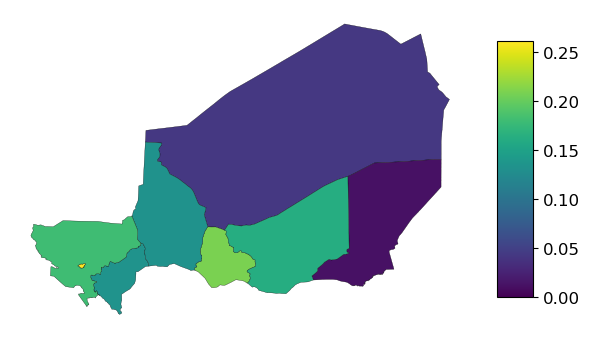

In [8]:
fig, ax = fn.plotLocationalColorMap(
    esM, "PV", path_to_regions, "GID_1", perArea=False
)

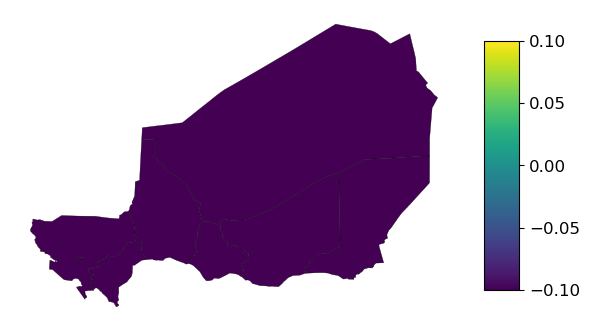

In [9]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Onshore", path_to_regions, "GID_1", perArea=False
)

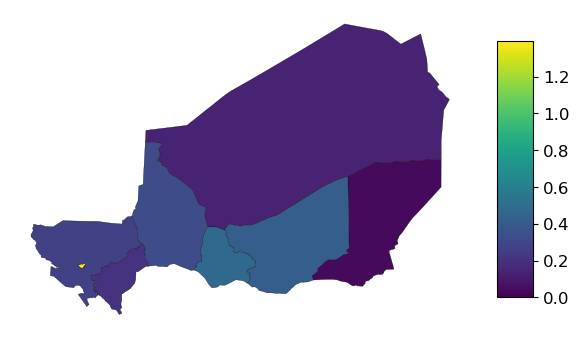

In [10]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Batteries", path_to_regions, "GID_1", perArea=False
)

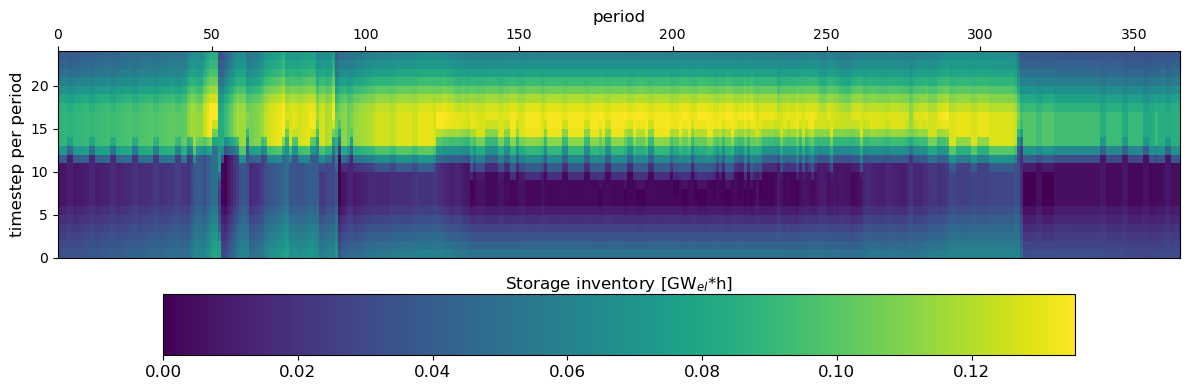

In [11]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Batteries",
    "NER.1_1",
    variableName="stateOfChargeOperationVariablesOptimum",
)